<a href="https://colab.research.google.com/github/connor-verheyen/COVID19_IndoorRH/blob/main/supplementary_analysis/Supplementary_Section_10__Additional_Information_For_Regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries 

import pandas as pd
import numpy as np
import scipy as sp 
import math
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# For a specific version of seaborn package 
!pip install seaborn==0.10.1

# Set seaborn plotting defaults
sns.set(context='talk', font_scale=0.9, style='whitegrid', palette='Blues_d')

In [ ]:
# Import Files 
filename='https://raw.githubusercontent.com/connor-verheyen/COVID19_IndoorRH/main/data/7DaySmooth_ALLVars_Dataset_2020_08_10_GE50_Deaths.csv'

df7all = pd.read_csv(filename) #df7all = pd.read_excel('7DaySmooth_ALLVars_Dataset_2020_08_10_GE50_Deaths.xlsx')

# Drop unnecessary index columns 
df7all.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [ ]:
# Tropic of Cancer is located at 23.5 degrees north of the equator and runs through Mexico, the Bahamas, Egypt, Saudi Arabia, India, and southern China
# The Tropic of Capricorn lies at 23.5 degrees south of the equator and runs through Australia, Chile, southern Brazil, and northern South Africa

upper_lat_bound = 23.5; lower_lat_bound = -23.5 

n_hem = df7all[df7all['Lat']>upper_lat_bound]
s_hem = df7all[df7all['Lat']<lower_lat_bound]
trop  = df7all[(df7all['Lat']<upper_lat_bound) & (df7all['Lat']>lower_lat_bound)]

In [ ]:
df7all.loc[:,'Region'] = ['n_hem' if country_name in n_hem['Country'].unique() else 's_hem' if country_name in s_hem['Country'].unique() else 'trop' for country_name in df7all.loc[:,'Country']]

In [ ]:
# Set seaborn plotting style 
sns.set(context='talk', font_scale=0.9, style='ticks', palette='Blues_d')

In [ ]:
# Function to create lags of a given variable 

def make_lags(dataframe,merging_var,variable,num_lags):
  df = dataframe[['Country',merging_var,variable]].copy() # Make a copy of the country (for grouping) and the variable to be lagged  

  for i in range(1,num_lags+1):
    df[variable+'_lag{}'.format(i)] = df.groupby('Country')[variable].shift(i) # Create all of the lags of the given input variable 

  return df

In [ ]:
# Function to create a dataframe with lagged versions of the variable and the actual outbreak metrics 

def lagged_var_df(dataframe,merging_var,variable,num_lags,COVIDstats):

  df = dataframe.copy()

  outcomes = df[COVIDstats]

  lagged_variables = make_lags(dataframe,merging_var,variable,num_lags)

  merged = lagged_variables.merge(right=outcomes,how='left',on=['Country',merging_var])

  return merged

### Full Dataframe, 7-Day Smoothing of ALL VARIABLES 

In [ ]:
# Make dataframe with outbreak metrics and lagged versions of indoor climate 
COVIDstats = ['Country','Days From 5th Death','total_cases', 'total_cases_per_million', 'new_cases', # Add country and date so there can be correct merging on keys 
       'new_cases_per_million', 'total_deaths', 'total_deaths_per_million',
       'total_deaths_pctchange', 'total_deaths_per_million_pctchange',
       'new_deaths', 'new_deaths_per_million', 'new_deaths_diff',
       'new_deaths_per_million_diff', 'new_deaths_pctchange',
       'new_deaths_per_million_pctchange']

df7all_lag_indrh = lagged_var_df(df7all,'Days From 5th Death','IndoorRH_pct',28,COVIDstats)

In [ ]:
# Datasets -> All countries, only NH, only SH, only Trop
all_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120)] 
nhem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(n_hem['Country'].unique()))]
shem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(s_hem['Country'].unique()))]
trop_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(trop['Country'].unique()))]

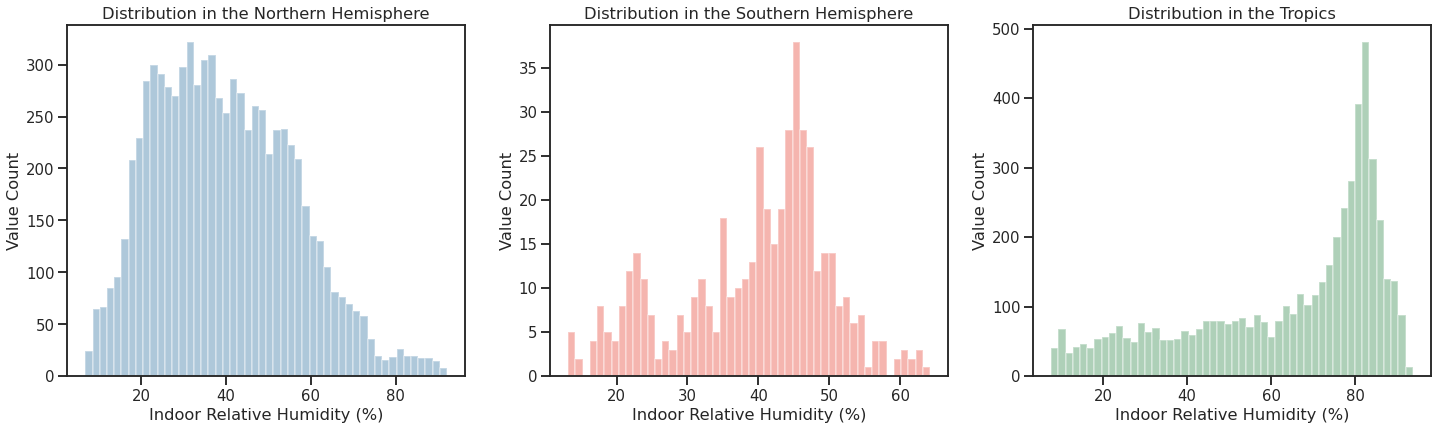

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,6))

sns.distplot(n_hem[(n_hem['Days From 5th Death'].ge(0)) & (n_hem['Days From 5th Death'].le(120))]['IndoorRH_pct'],ax=ax[0],kde=False,color=sns.color_palette(palette='Blues_d',n_colors=4)[1],bins=50)
sns.distplot(s_hem[(s_hem['Days From 5th Death'].ge(0)) & (s_hem['Days From 5th Death'].le(120))]['IndoorRH_pct'],ax=ax[1],kde=False,color=sns.color_palette(palette='Reds_d',n_colors=4)[2],bins=50)
sns.distplot(trop[(trop['Days From 5th Death'].ge(0)) & (trop['Days From 5th Death'].le(120))]['IndoorRH_pct'],ax=ax[2],kde=False,color=sns.color_palette(palette='Greens_d',n_colors=4)[1],bins=50)

ax[0].set_title('Distribution in the Northern Hemisphere')
ax[1].set_title('Distribution in the Southern Hemisphere')
ax[2].set_title('Distribution in the Tropics')

[ax.set_ylabel('Value Count') for ax in plt.gcf().axes]
[ax.set_xlabel('Indoor Relative Humidity (%)') for ax in plt.gcf().axes]

fig.tight_layout(pad=0.5,w_pad=1.5,h_pad=0.5)

# fig,ax=plt.subplots(1,3,figsize=(25,6))
# sns.distplot(n_hem['IndoorRH_pct'],ax=ax[0],hist=False,norm_hist=False,color=sns.color_palette(palette='Blues_d',n_colors=4)[1],bins=50)
# sns.distplot(s_hem['IndoorRH_pct'],ax=ax[1],hist=False,color=sns.color_palette(palette='Reds_d',n_colors=4)[2],bins=50)
# sns.distplot(trop['IndoorRH_pct'],ax=ax[2],hist=False,color=sns.color_palette(palette='Greens_d',n_colors=4)[1],bins=50)

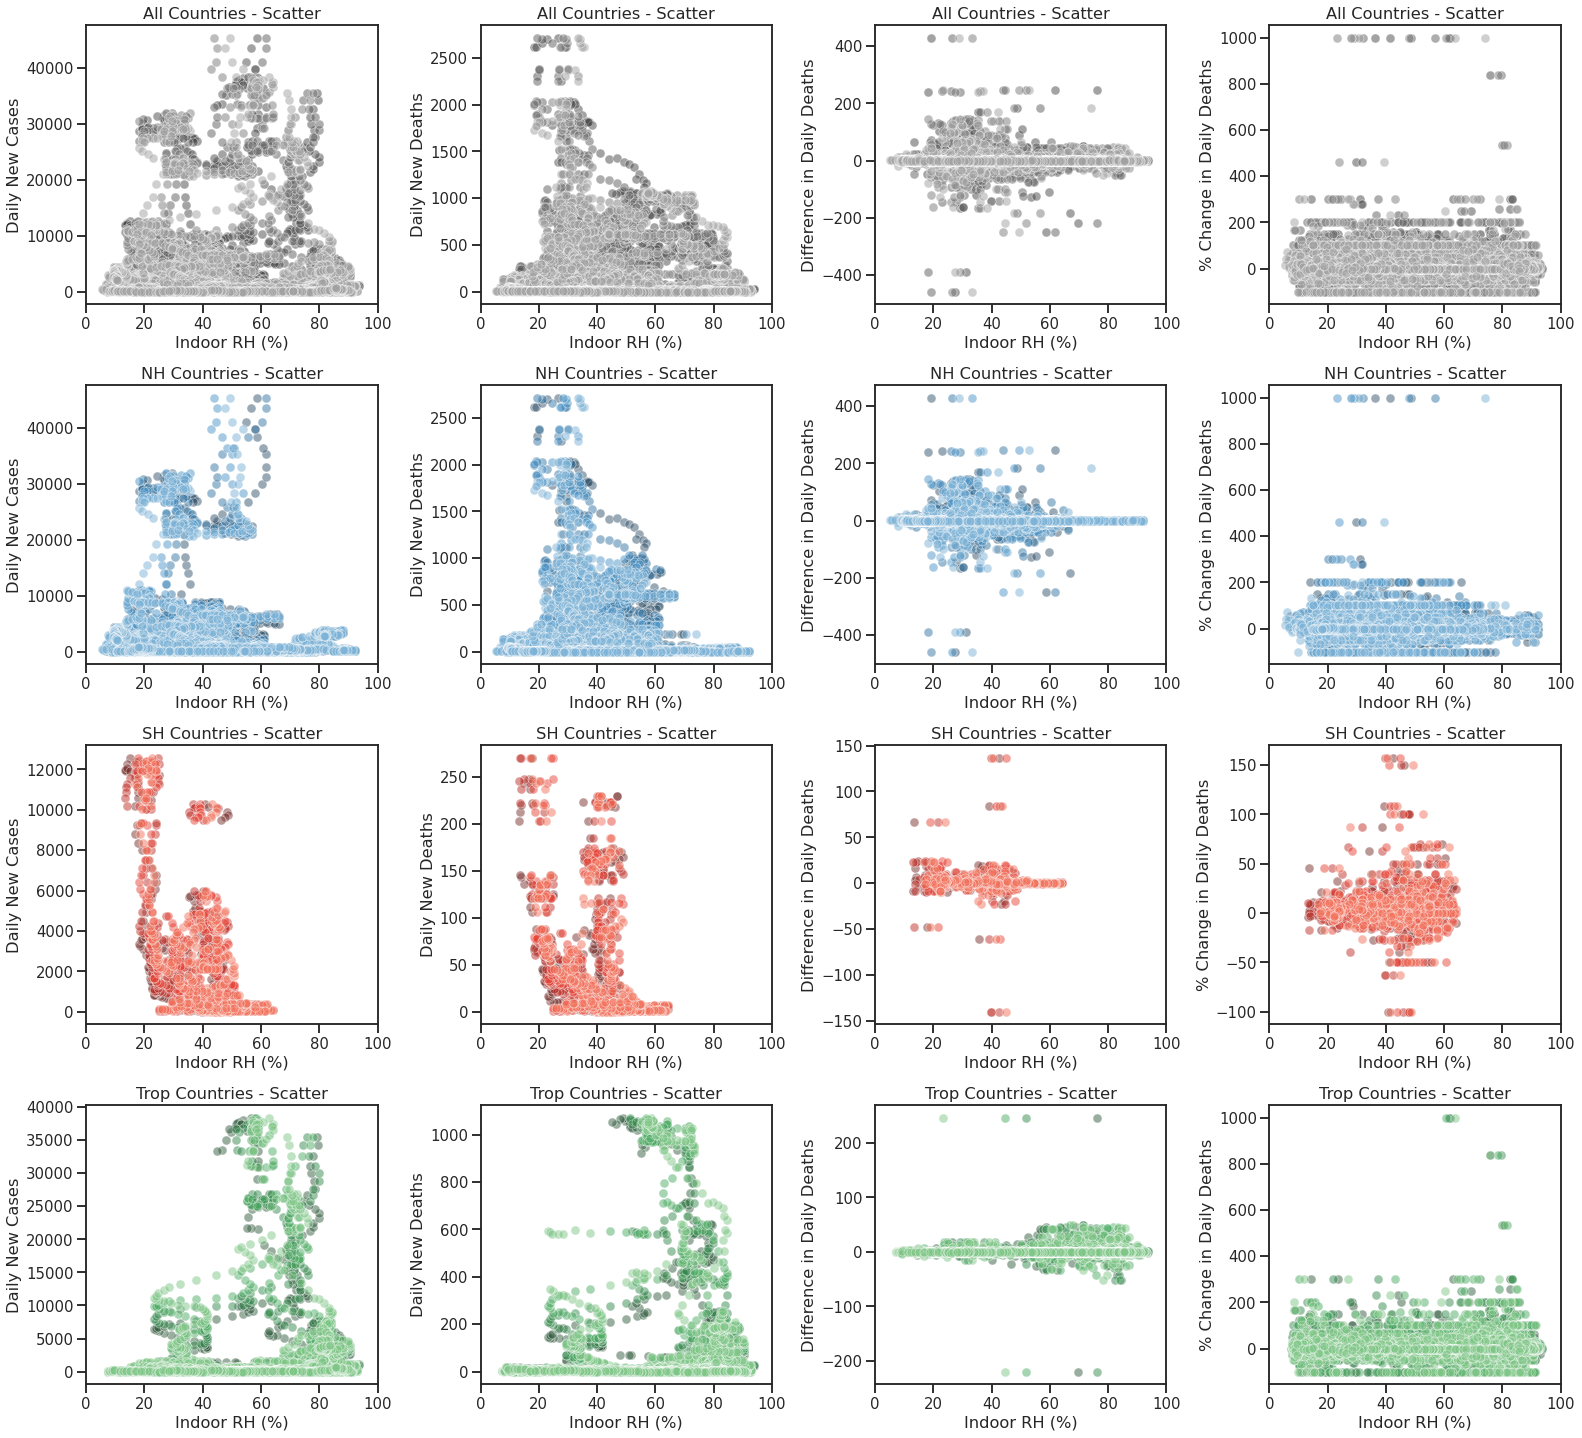

In [ ]:
all_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120)] 
nhem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(n_hem['Country'].unique()))]
shem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(s_hem['Country'].unique()))]
trop_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(trop['Country'].unique()))]

outcomes = ['new_cases','new_deaths','new_deaths_diff','new_deaths_pctchange']
rows = 4; cols = len(outcomes); fig,ax=plt.subplots(rows,cols,figsize=(22,20))

# Go through each quantized outbreak metric and make plots 
for col in range(0,cols): 

  # LOWESS for all countries 
  sns.scatterplot(x='IndoorRH_pct',y=outcomes[col],data=all_forplot,ax=ax[0,col],color=sns.color_palette(palette='Greys_d',n_colors=4)[0],alpha=0.5)
  sns.scatterplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=all_forplot,ax=ax[0,col],color=sns.color_palette(palette='Greys_d',n_colors=4)[1],alpha=0.5) 
  sns.scatterplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=all_forplot,ax=ax[0,col],color=sns.color_palette(palette='Greys_d',n_colors=4)[2],alpha=0.5)
  sns.scatterplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=all_forplot,ax=ax[0,col],color=sns.color_palette(palette='Greys_d',n_colors=4)[3],alpha=0.5)

  # LOWESS for n hem countries 
  sns.scatterplot(x='IndoorRH_pct',y=outcomes[col],data=nhem_forplot,ax=ax[1,col],color=sns.color_palette(palette='Blues_d',n_colors=4)[0],alpha=0.5)
  sns.scatterplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=nhem_forplot,ax=ax[1,col],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.5) 
  sns.scatterplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=nhem_forplot,ax=ax[1,col],color=sns.color_palette(palette='Blues_d',n_colors=4)[2],alpha=0.5)
  sns.scatterplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=nhem_forplot,ax=ax[1,col],color=sns.color_palette(palette='Blues_d',n_colors=4)[3],alpha=0.5)

  # LOWESS for s hem countries 
  sns.scatterplot(x='IndoorRH_pct',y=outcomes[col],data=shem_forplot,ax=ax[2,col],color=sns.color_palette(palette='Reds_d',n_colors=4)[0],alpha=0.5)
  sns.scatterplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=shem_forplot,ax=ax[2,col],color=sns.color_palette(palette='Reds_d',n_colors=4)[1],alpha=0.5) 
  sns.scatterplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=shem_forplot,ax=ax[2,col],color=sns.color_palette(palette='Reds_d',n_colors=4)[2],alpha=0.5)
  sns.scatterplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=shem_forplot,ax=ax[2,col],color=sns.color_palette(palette='Reds_d',n_colors=4)[3],alpha=0.5)

  # LOWESS for trop countries 
  sns.scatterplot(x='IndoorRH_pct',y=outcomes[col],data=trop_forplot,ax=ax[3,col],color=sns.color_palette(palette='Greens_d',n_colors=4)[0],alpha=0.5)
  sns.scatterplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=trop_forplot,ax=ax[3,col],color=sns.color_palette(palette='Greens_d',n_colors=4)[1],alpha=0.5) 
  sns.scatterplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=trop_forplot,ax=ax[3,col],color=sns.color_palette(palette='Greens_d',n_colors=4)[2],alpha=0.5)
  sns.scatterplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=trop_forplot,ax=ax[3,col],color=sns.color_palette(palette='Greens_d',n_colors=4)[3],alpha=0.5)

#[ax.legend(loc='upper right') for ax in plt.gcf().axes]
#[ax[r,3].legend(loc='upper right') for r in np.arange(0,4)]

[ax.set_xlim(0,100) for ax in plt.gcf().axes]

[ax[r,0].set_xlabel('Indoor RH (%)') for r in np.arange(0,4)]
[ax[r,1].set_xlabel('Indoor RH (%)') for r in np.arange(0,4)]
[ax[r,2].set_xlabel('Indoor RH (%)') for r in np.arange(0,4)]
[ax[r,3].set_xlabel('Indoor RH (%)') for r in np.arange(0,4)]

[ax[r,0].set_ylabel('Daily New Cases') for r in np.arange(0,4)]
[ax[r,1].set_ylabel('Daily New Deaths') for r in np.arange(0,4)]
[ax[r,2].set_ylabel('Difference in Daily Deaths') for r in np.arange(0,4)]
[ax[r,3].set_ylabel('% Change in Daily Deaths') for r in np.arange(0,4)]

ax[0,0].set_title('All Countries - Scatter')
ax[0,1].set_title('All Countries - Scatter')
ax[0,2].set_title('All Countries - Scatter')
ax[0,3].set_title('All Countries - Scatter')

ax[1,0].set_title('NH Countries - Scatter')
ax[1,1].set_title('NH Countries - Scatter')
ax[1,2].set_title('NH Countries - Scatter')
ax[1,3].set_title('NH Countries - Scatter')

ax[2,0].set_title('SH Countries - Scatter')
ax[2,1].set_title('SH Countries - Scatter')
ax[2,2].set_title('SH Countries - Scatter')
ax[2,3].set_title('SH Countries - Scatter')

ax[3,0].set_title('Trop Countries - Scatter')
ax[3,1].set_title('Trop Countries - Scatter')
ax[3,2].set_title('Trop Countries - Scatter')
ax[3,3].set_title('Trop Countries - Scatter')

#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

fig.tight_layout(pad=0.5,h_pad=1,w_pad=1)

# from google.colab import files
# filename = ('Figure_Robust_Fit_All_NH_SH_Trop.png')
# fig.savefig(filename, dpi=500)
# files.download(filename) 

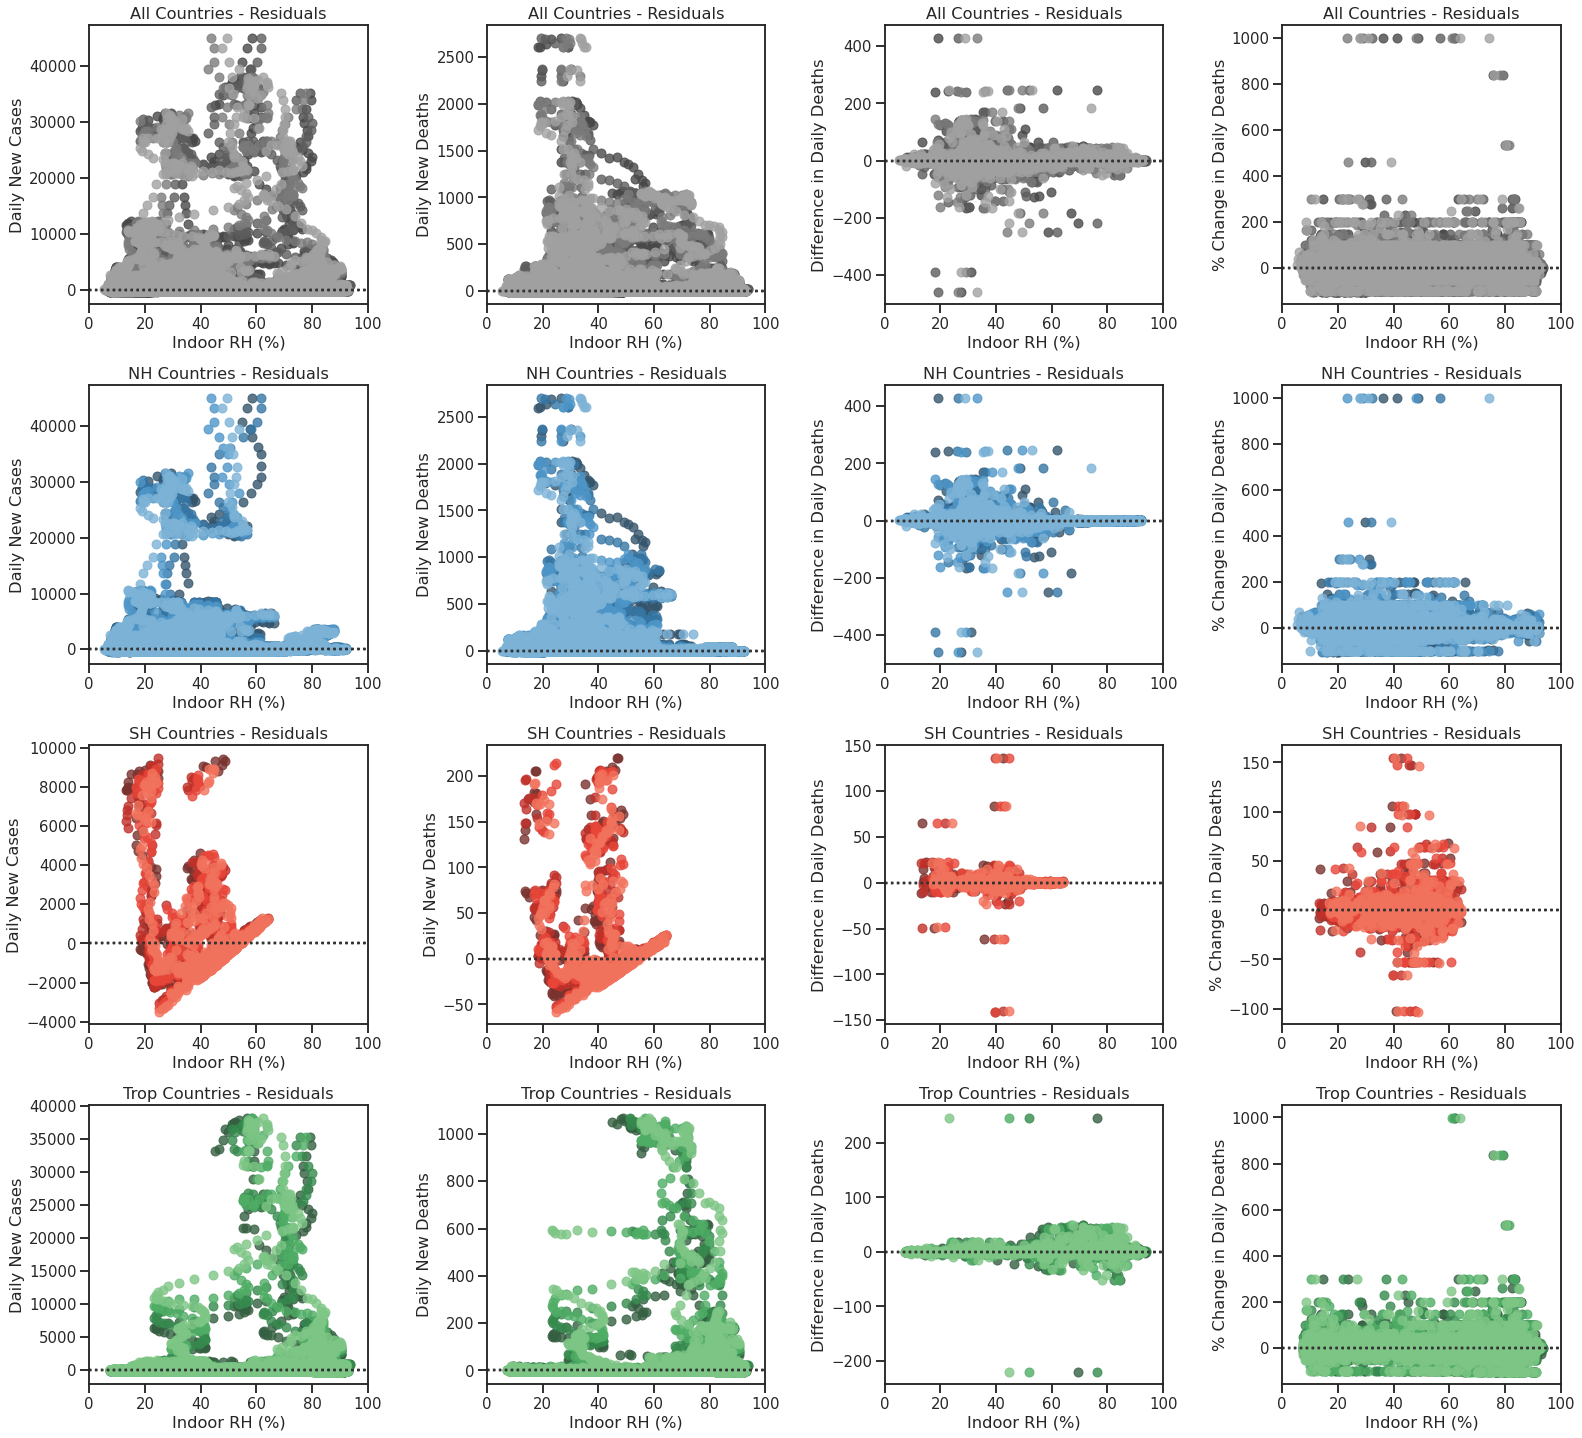

In [ ]:
all_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120)] 
nhem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(n_hem['Country'].unique()))]
shem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(s_hem['Country'].unique()))]
trop_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(trop['Country'].unique()))]

outcomes = ['new_cases','new_deaths','new_deaths_diff','new_deaths_pctchange']
rows = 4; cols = len(outcomes); fig,ax=plt.subplots(rows,cols,figsize=(22,20))

# Go through each quantized outbreak metric and make plots 
for col in range(0,cols): 

  # LOWESS for all countries 
  sns.residplot(x='IndoorRH_pct',y=outcomes[col],data=all_forplot,ax=ax[0,col],robust=True,label='No Lag',color=sns.color_palette(palette='Greys_d',n_colors=4)[0])
  sns.residplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=all_forplot,ax=ax[0,col],robust=True,label='1wk Lag',color=sns.color_palette(palette='Greys_d',n_colors=4)[1]) 
  sns.residplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=all_forplot,ax=ax[0,col],robust=True,label='2wk Lag',color=sns.color_palette(palette='Greys_d',n_colors=4)[2])
  sns.residplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=all_forplot,ax=ax[0,col],robust=True,label='3wk Lag',color=sns.color_palette(palette='Greys_d',n_colors=4)[3])

  # LOWESS for all countries 
  sns.residplot(x='IndoorRH_pct',y=outcomes[col],data=nhem_forplot,ax=ax[1,col],robust=True,label='No Lag',color=sns.color_palette(palette='Blues_d',n_colors=4)[0])
  sns.residplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=nhem_forplot,ax=ax[1,col],robust=True,label='1wk Lag',color=sns.color_palette(palette='Blues_d',n_colors=4)[1]) 
  sns.residplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=nhem_forplot,ax=ax[1,col],robust=True,label='2wk Lag',color=sns.color_palette(palette='Blues_d',n_colors=4)[2])
  sns.residplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=nhem_forplot,ax=ax[1,col],robust=True,label='3wk Lag',color=sns.color_palette(palette='Blues_d',n_colors=4)[3])

  # LOWESS for all countries 
  sns.residplot(x='IndoorRH_pct',y=outcomes[col],data=shem_forplot,ax=ax[2,col],robust=True,label='No Lag',color=sns.color_palette(palette='Reds_d',n_colors=4)[0])
  sns.residplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=shem_forplot,ax=ax[2,col],robust=True,label='1wk Lag',color=sns.color_palette(palette='Reds_d',n_colors=4)[1]) 
  sns.residplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=shem_forplot,ax=ax[2,col],robust=True,label='2wk Lag',color=sns.color_palette(palette='Reds_d',n_colors=4)[2])
  sns.residplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=shem_forplot,ax=ax[2,col],robust=True,label='3wk Lag',color=sns.color_palette(palette='Reds_d',n_colors=4)[3])

  # LOWESS for all countries 
  sns.residplot(x='IndoorRH_pct',y=outcomes[col],data=trop_forplot,ax=ax[3,col],robust=True,label='No Lag',color=sns.color_palette(palette='Greens_d',n_colors=4)[0])
  sns.residplot(x='IndoorRH_pct_lag7',y=outcomes[col],data=trop_forplot,ax=ax[3,col],robust=True,label='1wk Lag',color=sns.color_palette(palette='Greens_d',n_colors=4)[1]) 
  sns.residplot(x='IndoorRH_pct_lag14',y=outcomes[col],data=trop_forplot,ax=ax[3,col],robust=True,label='2wk Lag',color=sns.color_palette(palette='Greens_d',n_colors=4)[2])
  sns.residplot(x='IndoorRH_pct_lag21',y=outcomes[col],data=trop_forplot,ax=ax[3,col],robust=True,label='3wk Lag',color=sns.color_palette(palette='Greens_d',n_colors=4)[3])

[ax.set_xlim(0,100) for ax in plt.gcf().axes]

[ax[r,0].set_xlabel('Indoor RH (%)') for r in np.arange(0,4)]
[ax[r,1].set_xlabel('Indoor RH (%)') for r in np.arange(0,4)]
[ax[r,2].set_xlabel('Indoor RH (%)') for r in np.arange(0,4)]
[ax[r,3].set_xlabel('Indoor RH (%)') for r in np.arange(0,4)]

[ax[r,0].set_ylabel('Daily New Cases') for r in np.arange(0,4)]
[ax[r,1].set_ylabel('Daily New Deaths') for r in np.arange(0,4)]
[ax[r,2].set_ylabel('Difference in Daily Deaths') for r in np.arange(0,4)]
[ax[r,3].set_ylabel('% Change in Daily Deaths') for r in np.arange(0,4)]

ax[0,0].set_title('All Countries - Residuals')
ax[0,1].set_title('All Countries - Residuals')
ax[0,2].set_title('All Countries - Residuals')
ax[0,3].set_title('All Countries - Residuals')

ax[1,0].set_title('NH Countries - Residuals')
ax[1,1].set_title('NH Countries - Residuals')
ax[1,2].set_title('NH Countries - Residuals')
ax[1,3].set_title('NH Countries - Residuals')

ax[2,0].set_title('SH Countries - Residuals')
ax[2,1].set_title('SH Countries - Residuals')
ax[2,2].set_title('SH Countries - Residuals')
ax[2,3].set_title('SH Countries - Residuals')

ax[3,0].set_title('Trop Countries - Residuals')
ax[3,1].set_title('Trop Countries - Residuals')
ax[3,2].set_title('Trop Countries - Residuals')
ax[3,3].set_title('Trop Countries - Residuals')

fig.tight_layout(pad=0.5,h_pad=1,w_pad=2)

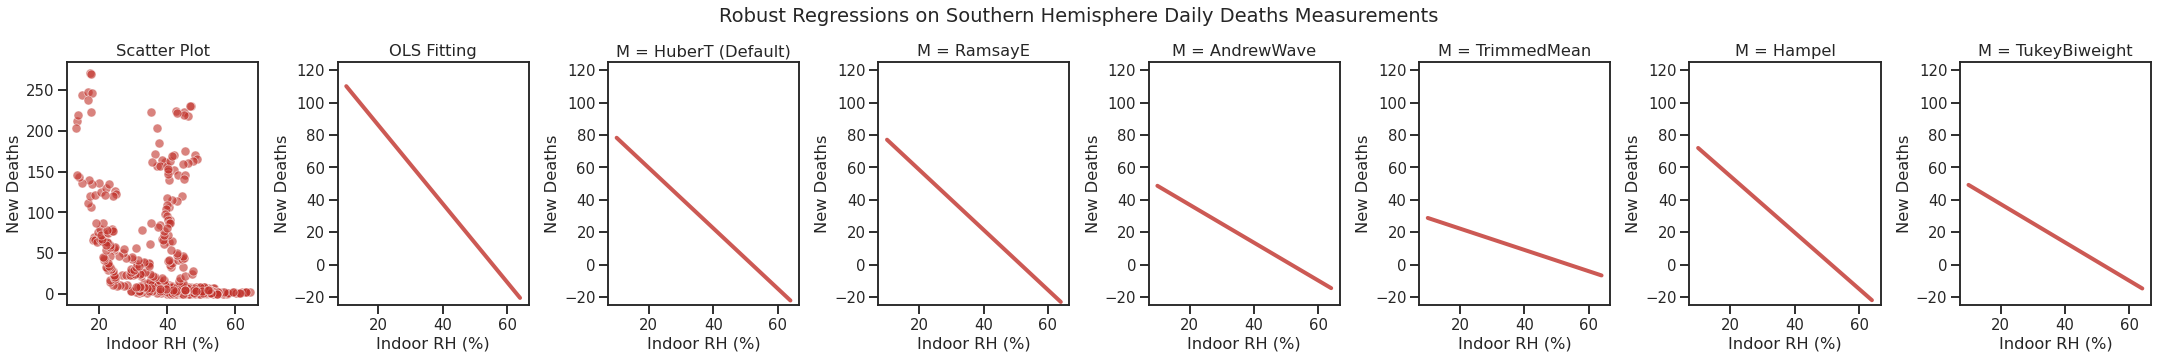

In [ ]:
import statsmodels.api as sm

shem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(s_hem['Country'].unique()))]

output=shem_forplot['new_deaths'].values
input=shem_forplot['IndoorRH_pct'].values
input=sm.add_constant(input)

fig,ax=plt.subplots(1,8,figsize=(30,5))

# Scatter plot of the datapoints 
sns.scatterplot(x='IndoorRH_pct',y='new_deaths',data=shem_forplot,ax=ax[0],color=sns.color_palette(palette='Reds_d',n_colors=4)[1],alpha=0.6)
ax[0].set_title('Scatter Plot')

# Fit and plot OLS model
ols_model = sm.OLS(endog=output,exog=input,missing='drop'); ols_results = ols_model.fit()
xvals=np.arange(10,65); yvals=(ols_results.params[0]+xvals*ols_results.params[1])
sns.lineplot(x=xvals,y=yvals,ax=ax[1],color=sns.color_palette(palette='Reds_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[1].set_title('OLS Fitting')

# Fit and plot Robust model
rlm_model = sm.RLM(endog=output,exog=input,missing='drop',M=sm.robust.norms.HuberT()) # Default method 
rlm_results = rlm_model.fit()
xvals=np.arange(10,65); yvals=(rlm_results.params[0]+xvals*rlm_results.params[1])
sns.lineplot(x=xvals,y=yvals,ax=ax[2],color=sns.color_palette(palette='Reds_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[2].set_title('M = HuberT (Default)')

# Fit and plot Robust model
rlm_model = sm.RLM(endog=output,exog=input,missing='drop',M=sm.robust.norms.RamsayE())
rlm_results = rlm_model.fit()
xvals=np.arange(10,65); yvals=(rlm_results.params[0]+xvals*rlm_results.params[1])
sns.lineplot(x=xvals,y=yvals,ax=ax[3],color=sns.color_palette(palette='Reds_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[3].set_title('M = RamsayE')

# Fit and plot Robust model
rlm_model = sm.RLM(endog=output,exog=input,missing='drop',M=sm.robust.norms.AndrewWave())
rlm_results = rlm_model.fit()
xvals=np.arange(10,65); yvals=(rlm_results.params[0]+xvals*rlm_results.params[1])
sns.lineplot(x=xvals,y=yvals,ax=ax[4],color=sns.color_palette(palette='Reds_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[4].set_title('M = AndrewWave')

# Fit and plot Robust model
rlm_model = sm.RLM(endog=output,exog=input,missing='drop',M=sm.robust.norms.TrimmedMean())
rlm_results = rlm_model.fit()
xvals=np.arange(10,65); yvals=(rlm_results.params[0]+xvals*rlm_results.params[1])
sns.lineplot(x=xvals,y=yvals,ax=ax[5],color=sns.color_palette(palette='Reds_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[5].set_title('M = TrimmedMean')

# Fit and plot Robust model
rlm_model = sm.RLM(endog=output,exog=input,missing='drop',M=sm.robust.norms.Hampel())
rlm_results = rlm_model.fit()
xvals=np.arange(10,65); yvals=(rlm_results.params[0]+xvals*rlm_results.params[1])
sns.lineplot(x=xvals,y=yvals,ax=ax[6],color=sns.color_palette(palette='Reds_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[6].set_title('M = Hampel')

# Fit and plot Robust model
rlm_model = sm.RLM(endog=output,exog=input,missing='drop',M=sm.robust.norms.TukeyBiweight())
rlm_results = rlm_model.fit()
xvals=np.arange(10,65); yvals=(rlm_results.params[0]+xvals*rlm_results.params[1])
sns.lineplot(x=xvals,y=yvals,ax=ax[7],color=sns.color_palette(palette='Reds_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[7].set_title('M = TukeyBiweight')

[ax[c].set_ylim(-25,125) for c in np.arange(1,8)]
[ax.set_xlabel('Indoor RH (%)') for ax in plt.gcf().axes]
[ax.set_ylabel('New Deaths') for ax in plt.gcf().axes]

fig.suptitle('Robust Regressions on Southern Hemisphere Daily Deaths Measurements')
fig.tight_layout(pad=0.5,h_pad=1,w_pad=1,rect=[0, 0, 1, 0.90])


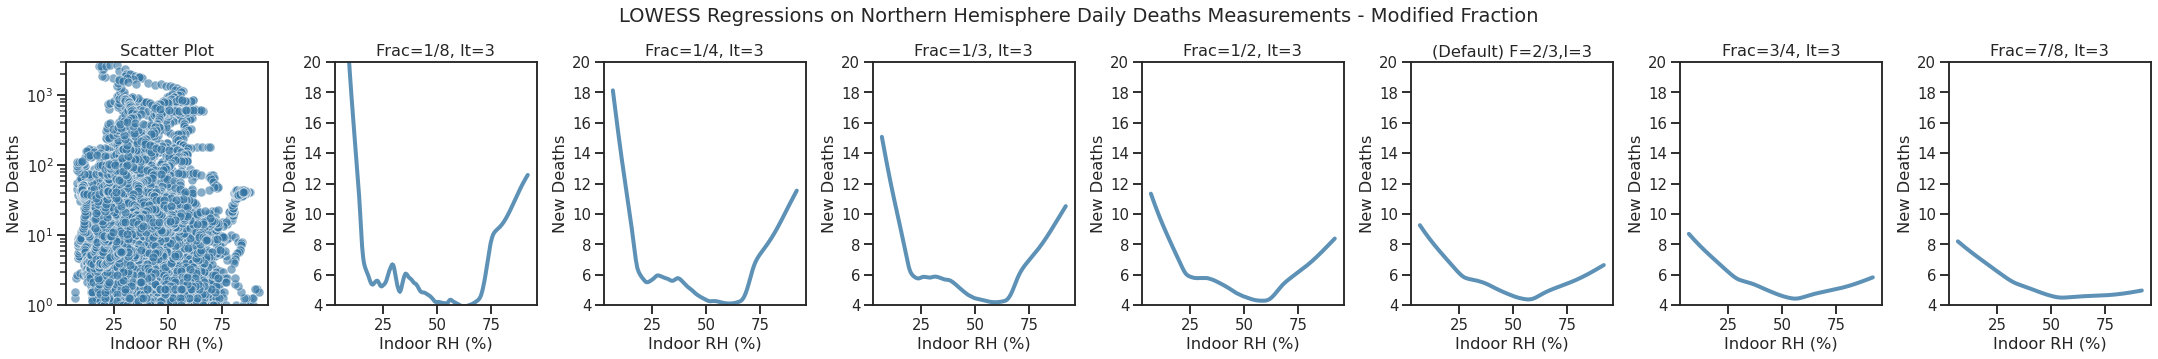

In [ ]:
#all_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120)] 
#nhem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(n_hem['Country'].unique()))].dropna()
#shem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(s_hem['Country'].unique()))]
#trop_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(trop['Country'].unique()))]

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

nhem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(n_hem['Country'].unique()))].dropna()
output=nhem_forplot['new_deaths'].values
input=nhem_forplot['IndoorRH_pct'].values


fig,ax=plt.subplots(1,8,figsize=(30,5))

# Scatter plot of the datapoints 
sns.scatterplot(x='IndoorRH_pct',y='new_deaths',data=nhem_forplot,ax=ax[0],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.6)
ax[0].set_title('Scatter Plot')

# Fit and plot modified lowess model
smooth = lowess(endog=output,exog=input,frac=0.875, it=3)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[7],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[7].set_title('Frac=7/8, It=3')

# Fit and plot modified lowess model
smooth = lowess(endog=output,exog=input,frac=0.75, it=3)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[6],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[6].set_title('Frac=3/4, It=3')

# Fit and plot default lowess model
smooth = lowess(endog=output,exog=input,frac=0.6666666666666666, it=3)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[5],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[5].set_title('(Default) F=2/3,I=3')

# Fit and plot modified lowess model
smooth = lowess(endog=output,exog=input,frac=0.5, it=3)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[4],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[4].set_title('Frac=1/2, It=3')

# Fit and plot modified lowess model
smooth = lowess(endog=output,exog=input,frac=0.333333333333333, it=3)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[3],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[3].set_title('Frac=1/3, It=3')

# Fit and plot modified lowess model
smooth = lowess(endog=output,exog=input,frac=0.25, it=3)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[2],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[2].set_title('Frac=1/4, It=3')

# Fit and plot modified lowess model
smooth = lowess(endog=output,exog=input,frac=0.125, it=3)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[1],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[1].set_title('Frac=1/8, It=3')

ax[0].set_yscale('log'); ax[0].set_ylim(1e0,3e3)
[ax[c].set_ylim(4,20) for c in np.arange(1,8)]
[ax.set_xlabel('Indoor RH (%)') for ax in plt.gcf().axes]
[ax.set_ylabel('New Deaths') for ax in plt.gcf().axes]

fig.suptitle('LOWESS Regressions on Northern Hemisphere Daily Deaths Measurements - Modified Fraction')
fig.tight_layout(pad=0.5,h_pad=1,w_pad=1,rect=[0, 0, 1, 0.90])

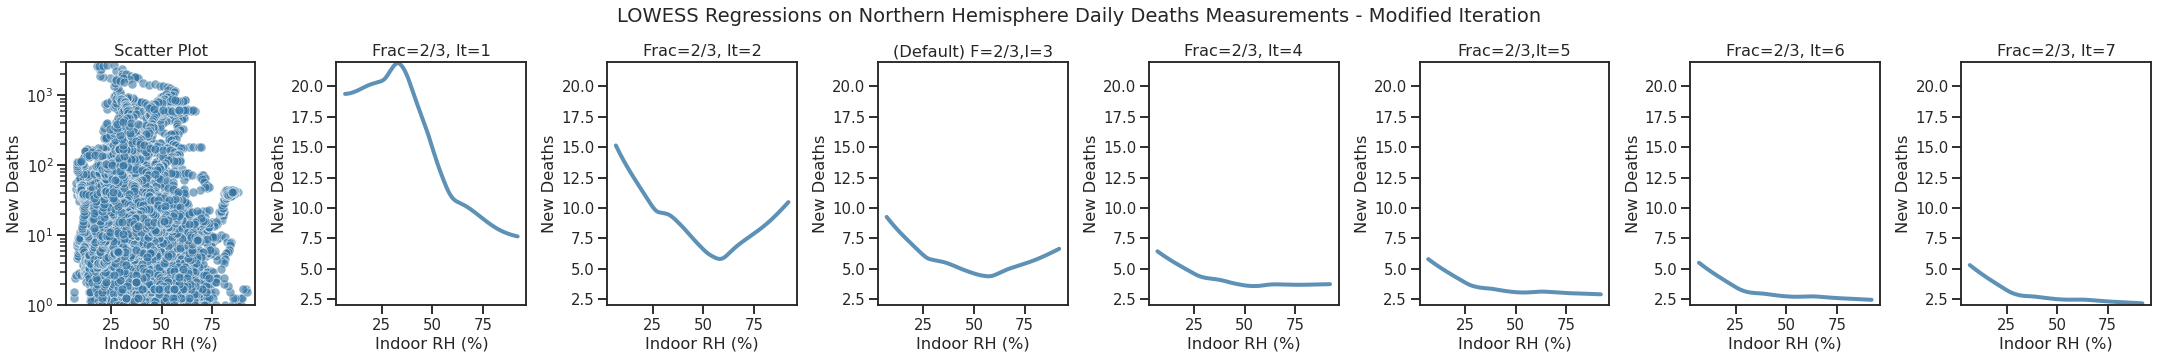

In [ ]:
#all_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120)] 
#nhem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(n_hem['Country'].unique()))].dropna()
#shem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(s_hem['Country'].unique()))]
#trop_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(trop['Country'].unique()))]

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

nhem_forplot = df7all_lag_indrh[(df7all_lag_indrh['Days From 5th Death']>=0) & (df7all_lag_indrh['Days From 5th Death']<=120) & (df7all_lag_indrh['Country'].isin(n_hem['Country'].unique()))].dropna()
output=nhem_forplot['new_deaths'].values
input=nhem_forplot['IndoorRH_pct'].values


fig,ax=plt.subplots(1,8,figsize=(30,5))

# Scatter plot of the datapoints 
sns.scatterplot(x='IndoorRH_pct',y='new_deaths',data=nhem_forplot,ax=ax[0],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.6)
ax[0].set_title('Scatter Plot')

# Fit and plot modified lowess model
smooth = lowess(endog=output,exog=input,frac=0.6666666666666666, it=7)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[7],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[7].set_title('Frac=2/3, It=7')

# Fit and plot modified lowess model
smooth = lowess(endog=output,exog=input,frac=0.6666666666666666, it=6)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[6],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[6].set_title('Frac=2/3, It=6')

# Fit and plot default lowess model
smooth = lowess(endog=output,exog=input,frac=0.6666666666666666, it=5)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[5],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[5].set_title('Frac=2/3,It=5')

# Fit and plot modified lowess model
smooth = lowess(endog=output,exog=input,frac=0.6666666666666666, it=4)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[4],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[4].set_title('Frac=2/3, It=4')

# Fit and plot modified lowess model
smooth = lowess(endog=output,exog=input,frac=0.6666666666666666, it=3)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[3],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[3].set_title('(Default) F=2/3,I=3')

# Fit and plot modified lowess model
smooth = lowess(endog=output,exog=input,frac=0.6666666666666666, it=2)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[2],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[2].set_title('Frac=2/3, It=2')

# Fit and plot modified lowess model
smooth = lowess(endog=output,exog=input,frac=0.6666666666666666, it=1)
sns.lineplot(x=smooth[:,0],y=smooth[:,1],ax=ax[1],color=sns.color_palette(palette='Blues_d',n_colors=4)[1],alpha=0.8,linewidth=4)
ax[1].set_title('Frac=2/3, It=1')

ax[0].set_yscale('log'); ax[0].set_ylim(1e0,3e3)
[ax[c].set_ylim(2,22) for c in np.arange(1,8)]
[ax.set_xlabel('Indoor RH (%)') for ax in plt.gcf().axes]
[ax.set_ylabel('New Deaths') for ax in plt.gcf().axes]

fig.suptitle('LOWESS Regressions on Northern Hemisphere Daily Deaths Measurements - Modified Iteration')
fig.tight_layout(pad=0.5,h_pad=1,w_pad=1,rect=[0, 0, 1, 0.90])

In [ ]:
def lagged_correlations(dataframe,merging_var,variable,num_lags,COVIDstats):

  df = dataframe.copy()

  df_lagged = lagged_var_df(df,merging_var,variable,num_lags,COVIDstats)

  corr = df_lagged[df_lagged['Days From 5th Death'].ge(-7)].corr(method='spearman')

  trimmed = corr.iloc[1:num_lags+2,num_lags+2:].reset_index()

  return corr,trimmed

In [ ]:
def lagged_correlations_plot(dataframe,merging_var,variable,num_lags,COVIDstats):

  df = dataframe.copy()

  corr,trimmed = lagged_correlations(df,merging_var,variable,num_lags,COVIDstats)

  fig,ax = plt.subplots(figsize=(10,10))

  for covstat in COVIDstats:
    if covstat not in ('Country','Days From 5th Death'):
      #print(covstat)
      trimmed[covstat].plot(ax=ax)
  plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
  plt.title(variable)
  plt.xlabel('Lags')
  plt.ylabel('Correlation')
  plt.gca().invert_xaxis()
  fig.show()

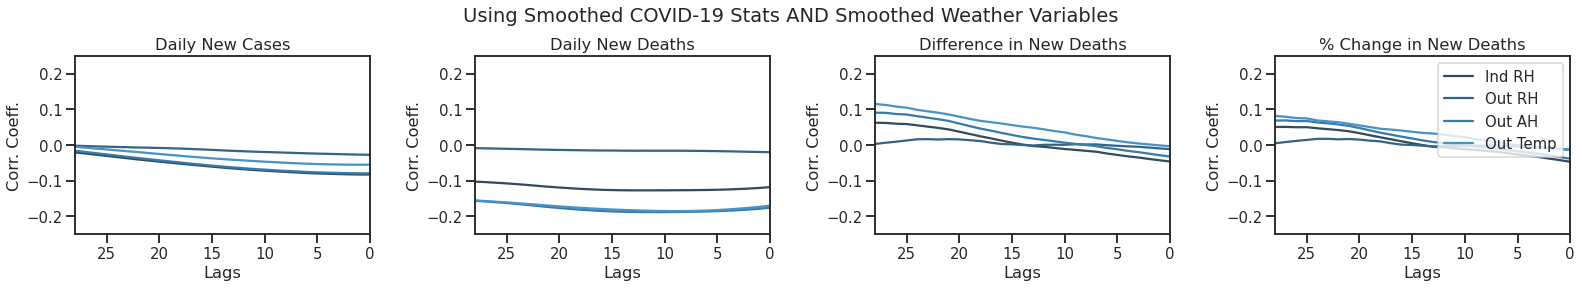

In [ ]:
dataset = df7all[(df7all['Days From 5th Death'].ge(0)) & (df7all['Days From 5th Death'].le(120))]

# Calculate lagged correlations between different weather variables and the covid outcomes 

correlations_indrh,trimmed_correlations_indrh = lagged_correlations(dataset,'Days From 5th Death','IndoorRH_pct',28,COVIDstats)
correlations_outtemp,trimmed_correlations_outtemp = lagged_correlations(dataset,'Days From 5th Death','DailyTemp_C',28,COVIDstats)
correlations_outrh,trimmed_correlations_outrh = lagged_correlations(dataset,'Days From 5th Death','DailyRH_pct',28,COVIDstats)
correlations_outah,trimmed_correlations_outah = lagged_correlations(dataset,'Days From 5th Death','DailyAH_gperm3',28,COVIDstats)

# Plot lagged correlations between weather and covid outcomes 
outcomes = ['new_cases','new_deaths','new_deaths_diff','new_deaths_pctchange']
rows = 1
cols = len(outcomes)

fig,ax=plt.subplots(rows,cols,figsize=(22,4))

for col in range(0,cols):
  sns.lineplot(x=np.arange(0,29),y=outcomes[col],data=trimmed_correlations_indrh,ax=ax[col],label='Ind RH',legend=False)
  sns.lineplot(x=np.arange(0,29),y=outcomes[col],data=trimmed_correlations_outrh,ax=ax[col],label='Out RH',legend=False)
  sns.lineplot(x=np.arange(0,29),y=outcomes[col],data=trimmed_correlations_outah,ax=ax[col],label='Out AH',legend=False)
  sns.lineplot(x=np.arange(0,29),y=outcomes[col],data=trimmed_correlations_outtemp,ax=ax[col],label='Out Temp',legend=False)
  ax[col].set_xlim(28,0)
  #sns.regplot(x=lagged_col_names[0],y=outcomes[col],data=dataframe,ax=ax[col],robust=True,scatter=False,n_boot=500,label='No Lag') #;sns.despine()

#ax[3].legend(loc='upper right')

ax[0].set_ylabel('Corr. Coeff.')
ax[1].set_ylabel('Corr. Coeff.')
ax[2].set_ylabel('Corr. Coeff.')
ax[3].set_ylabel('Corr. Coeff.')

ax[0].set_xlabel('Lags')
ax[1].set_xlabel('Lags')
ax[2].set_xlabel('Lags')
ax[3].set_xlabel('Lags')

ax[0].set_title('Daily New Cases')
ax[1].set_title('Daily New Deaths')
ax[2].set_title('Difference in New Deaths')
ax[3].set_title('% Change in New Deaths')

ax[0].set_ylim(-0.25,0.25)
ax[1].set_ylim(-0.25,0.25)
ax[2].set_ylim(-0.25,0.25)
ax[3].set_ylim(-0.25,0.25)

ax[3].legend(loc='upper right')

#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

fig.suptitle('Using Smoothed COVID-19 Stats AND Smoothed Weather Variables')

fig.tight_layout(pad=0.5,h_pad=0.8,w_pad=2,rect=[0,0,1,0.9])

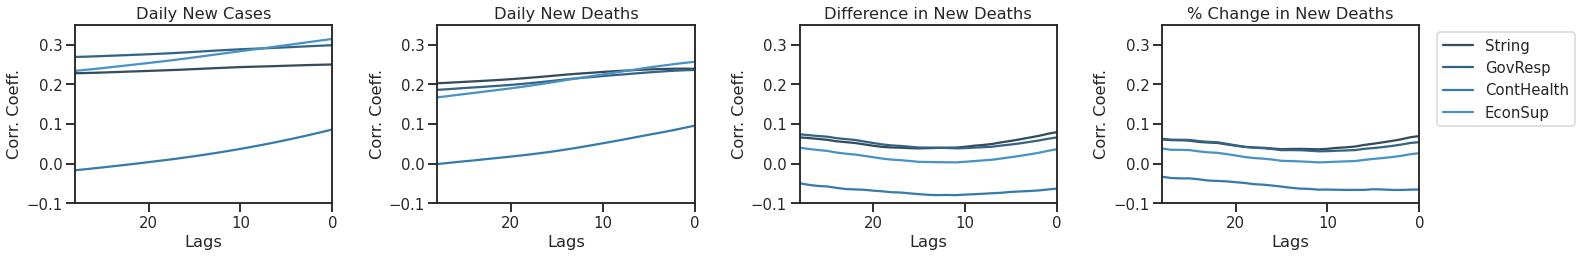

In [ ]:
dataset = df7all[(df7all['Days From 5th Death'].ge(0)) & (df7all['Days From 5th Death'].le(120))]

correlations_indrh,trimmed_correlations_indrh = lagged_correlations(dataset,'Days From 5th Death','StringencyIndexForDisplay',28,COVIDstats)
correlations_outtemp,trimmed_correlations_outtemp = lagged_correlations(dataset,'Days From 5th Death','GovernmentResponseIndexForDisplay',28,COVIDstats)
correlations_outrh,trimmed_correlations_outrh = lagged_correlations(dataset,'Days From 5th Death','ContainmentHealthIndexForDisplay',28,COVIDstats)
correlations_outah,trimmed_correlations_outah = lagged_correlations(dataset,'Days From 5th Death','EconomicSupportIndexForDisplay',28,COVIDstats)

# Plot lagged correlations between weather and covid outcomes 
outcomes = ['new_cases','new_deaths','new_deaths_diff','new_deaths_pctchange']
rows = 1
cols = len(outcomes)

fig,ax=plt.subplots(rows,cols,figsize=(22,4))

for col in range(0,cols):
  sns.lineplot(x=np.arange(0,29),y=outcomes[col],data=trimmed_correlations_indrh,ax=ax[col],label='String',legend=False)
  sns.lineplot(x=np.arange(0,29),y=outcomes[col],data=trimmed_correlations_outrh,ax=ax[col],label='GovResp',legend=False)
  sns.lineplot(x=np.arange(0,29),y=outcomes[col],data=trimmed_correlations_outah,ax=ax[col],label='ContHealth',legend=False)
  sns.lineplot(x=np.arange(0,29),y=outcomes[col],data=trimmed_correlations_outtemp,ax=ax[col],label='EconSup',legend=False)
  ax[col].set_xlim(28,0)
  #sns.regplot(x=lagged_col_names[0],y=outcomes[col],data=dataframe,ax=ax[col],robust=True,scatter=False,n_boot=500,label='No Lag') #;sns.despine()

#ax[3].legend(loc='upper right')

ax[0].set_ylabel('Corr. Coeff.')
ax[1].set_ylabel('Corr. Coeff.')
ax[2].set_ylabel('Corr. Coeff.')
ax[3].set_ylabel('Corr. Coeff.')

ax[0].set_xlabel('Lags')
ax[1].set_xlabel('Lags')
ax[2].set_xlabel('Lags')
ax[3].set_xlabel('Lags')

ax[0].set_title('Daily New Cases')
ax[1].set_title('Daily New Deaths')
ax[2].set_title('Difference in New Deaths')
ax[3].set_title('% Change in New Deaths')

ax[0].set_ylim(-0.1,0.35)
ax[1].set_ylim(-0.1,0.35)
ax[2].set_ylim(-0.1,0.35)
ax[3].set_ylim(-0.1,0.35)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

#fig.suptitle('Using Smoothed COVID-19 Stats and Weather Variables')

fig.tight_layout(pad=0.5,h_pad=0.8,w_pad=2,rect=[0,0,1,0.9])